In [81]:
%pip install pyspark
%pip install delta-spark

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [82]:
from spark_session import get_spark_session

spark = get_spark_session("SilverDeltaNotebook")

### Data Analysis for Silver Table

In [83]:
from pyspark.sql.functions import when, count, avg, round, col, isnan, date_format

In [84]:
silver_df = spark.read.table("bronze_nyc_trips")
silver_df.show()

+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+------------------+-----------+
|VendorID|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|RatecodeID|store_and_fwd_flag|PULocationID|DOLocationID|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|total_amount|congestion_surcharge|Airport_fee|cbd_congestion_fee|pickup_date|
+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+------------------+-----------+
|       2| 2025-01-01 21:21:42|  2025-01-01 21:34:28|            1.0|         2.31|       1.0|

In [85]:
# Fare amount should not be negative it could be data entry error or discount since we cannot prove either we filter rows where total_amount is less than 0

silver_df.filter(silver_df['total_amount'] < 0).count()

38975

In [86]:
# By analyzing the data, we can see that there are trip_distances that are greater than 100's of miles, which is not realistic for a taxi trip in NYC.

silver_df.orderBy("trip_distance", ascending=False).show()

+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+------------------+-----------+
|VendorID|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|RatecodeID|store_and_fwd_flag|PULocationID|DOLocationID|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|total_amount|congestion_surcharge|Airport_fee|cbd_congestion_fee|pickup_date|
+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+------------------+-----------+
|       2| 2025-01-24 08:33:00|  2025-01-24 08:44:00|            NaN|    168079.57|       NaN|

In [87]:
# Grouping trip distances into ranges and calculating average fare amounts to verify large trip distances we found earlier

silver_df.select(
    count(when((silver_df.trip_distance >= 0) & (silver_df.trip_distance <= 100), 1)).alias("0-100"),
    round(avg(when((silver_df.trip_distance >= 0) & (silver_df.trip_distance <= 100), silver_df.fare_amount)), 2).alias("avg 0-100"),
    count(when((silver_df.trip_distance >= 101) & (silver_df.trip_distance <= 500), 1)).alias("100-500"),
    round(avg(when((silver_df.trip_distance >= 101) & (silver_df.trip_distance <= 500), silver_df.fare_amount)), 2).alias("avg 100-500"),
    count(when((silver_df.trip_distance >= 501), 1)).alias("501+"),
    round(avg(when((silver_df.trip_distance >= 501), silver_df.fare_amount)), 2).alias("avg 501+")
).show()

+-------+---------+-------+-----------+----+--------+
|  0-100|avg 0-100|100-500|avg 100-500|501+|avg 501+|
+-------+---------+-------+-----------+----+--------+
|2008081|    17.25|     26|     407.18|  22|   16.06|
+-------+---------+-------+-----------+----+--------+



In [88]:
# Calculate fare per mile for trips

silver_df = silver_df \
            .filter(col("trip_distance") != 0) \
            .filter(col("total_amount") > 0) \
            .filter(col("passenger_count") > 0) \
            .withColumn("fare_per_mile", round(col("fare_amount") / col("trip_distance"))) \
            .withColumn("dropoff_date", col("tpep_dropoff_datetime").cast("date")) \
            .withColumn("pickup_time", date_format("tpep_pickup_datetime", "HH:mm:ss")) \
            .withColumn("dropoff_time", date_format("tpep_dropoff_datetime", "HH:mm:ss"))
silver_df = silver_df.drop("tpep_pickup_datetime", "tpep_dropoff_datetime")
silver_df.show()

+--------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+------------------+-----------+-------------+------------+-----------+------------+
|VendorID|passenger_count|trip_distance|RatecodeID|store_and_fwd_flag|PULocationID|DOLocationID|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|total_amount|congestion_surcharge|Airport_fee|cbd_congestion_fee|pickup_date|fare_per_mile|dropoff_date|pickup_time|dropoff_time|
+--------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+------------------+-----------+-------------+------------+-----------+------------+
|       1|            1.0|          0.1|       1.0|                

In [89]:
from pyspark.sql.types import NumericType

column = [c for c in silver_df.columns if c not in ['pickup_date', 'dropoff_date', 'pickup_time', 'dropoff_time']]
silver_df.select([count(when((isnan(c) if isinstance(silver_df.schema[c].dataType, NumericType) else False) | col(c).isNull(), c)).alias(c) for c in column]).show()

+--------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+------------------+-------------+
|VendorID|passenger_count|trip_distance|RatecodeID|store_and_fwd_flag|PULocationID|DOLocationID|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|total_amount|congestion_surcharge|Airport_fee|cbd_congestion_fee|fare_per_mile|
+--------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+------------------+-------------+
|       0|          78987|            0|     78987|             78987|           0|           0|           0|          0|    0|      0|         0|           0|                    0|           0|               78987|  

In [90]:
silver_df = silver_df.dropna()

In [91]:
silver_df.select([count(when((isnan(c) if isinstance(silver_df.schema[c].dataType, NumericType) else False) | col(c).isNull(), c)).alias(c) for c in column]).show()

+--------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+------------------+-------------+
|VendorID|passenger_count|trip_distance|RatecodeID|store_and_fwd_flag|PULocationID|DOLocationID|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|total_amount|congestion_surcharge|Airport_fee|cbd_congestion_fee|fare_per_mile|
+--------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+------------------+-------------+
|       0|              0|            0|         0|                 0|           0|           0|           0|          0|    0|      0|         0|           0|                    0|           0|                   0|  

Text(0.5, 1.0, 'Fare per Mile Distribution')

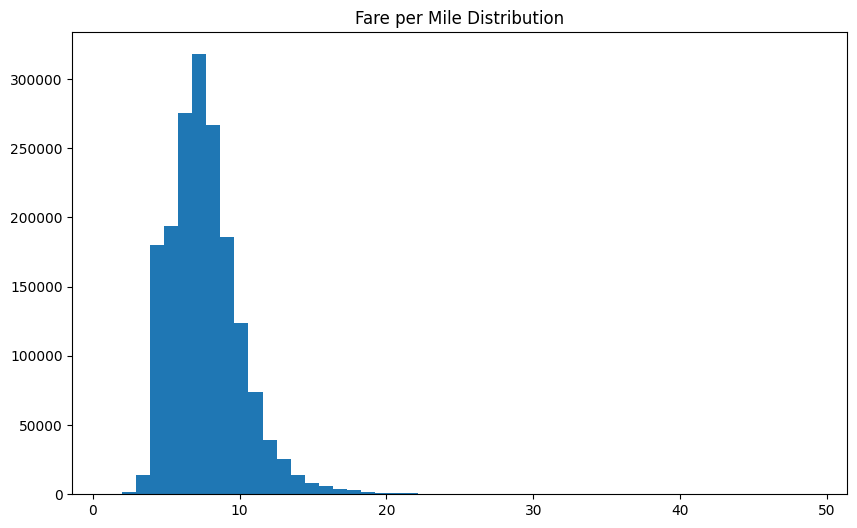

In [92]:
import matplotlib.pyplot as plt

pandas_df = silver_df.filter(
    (silver_df.fare_per_mile.isNotNull()) &
    (silver_df.fare_per_mile > 0) &
    (col('trip_distance') > 0.5) &
    (col('fare_per_mile') <= 50)  &
    (col('fare_per_mile') > 0) &
    (silver_df.fare_per_mile < 50)).toPandas()
plt.figure(figsize=(10, 6))
plt.hist(pandas_df['fare_per_mile'], bins=50)
plt.title('Fare per Mile Distribution')

In [93]:
from pyspark.sql import functions as F

silver_df.filter((col('trip_distance') > 0.5) & (col('fare_per_mile') <= 50) & (col('fare_per_mile') > 0)).select(
    F.min("fare_per_mile").alias("min_fpm"),
    F.max("fare_per_mile").alias("max_fpm"),
    F.mean("fare_per_mile").alias("avg_fpm")
).show()

silver_df.filter((col('trip_distance') > 0.5)  & (col('fare_per_mile') <= 50)  & (col('fare_per_mile') > 0)).select("fare_amount", "trip_distance", "fare_per_mile").orderBy(F.desc('fare_per_mile'), F.desc('fare_amount'), 'trip_distance').show(20)


+-------+-------+-----------------+
|min_fpm|max_fpm|          avg_fpm|
+-------+-------+-----------------+
|    1.0|   50.0|7.455158698226213|
+-------+-------+-----------------+

+-----------+-------------+-------------+
|fare_amount|trip_distance|fare_per_mile|
+-----------+-------------+-------------+
|       95.0|          1.9|         50.0|
|       84.0|         1.67|         50.0|
|       70.0|          1.4|         50.0|
|       70.0|          1.4|         50.0|
|       70.0|          1.4|         50.0|
|       70.0|          1.4|         50.0|
|       70.0|         1.41|         50.0|
|       70.0|         1.41|         50.0|
|       70.0|         1.41|         50.0|
|       65.0|          1.3|         50.0|
|       65.0|          1.3|         50.0|
|       30.0|          0.6|         50.0|
|       30.0|          0.6|         50.0|
|       30.0|          0.6|         50.0|
|      149.0|         3.02|         49.0|
|       84.0|          1.7|         49.0|
|       70.0|        

In [94]:
print(silver_df.count())
# 1. Filter extreme trip distances (>50 miles for NYC)
silver_df = silver_df.filter(col("trip_distance") <= 50)
print(silver_df.count())
# 2. Validate location IDs (1-263 range)
silver_df = silver_df.filter(
    (col("PULocationID").between(1, 263)) & 
    (col("DOLocationID").between(1, 263))
)
print(silver_df.count())
# 3. Validate rate codes (1-6)
silver_df = silver_df.filter(col("RatecodeID").between(1, 6))
print(silver_df.count())

# 4. Validate payment types (1-6)
silver_df = silver_df.filter(col("payment_type").between(1, 6))
print(silver_df.count())

# 5. Ensure non-negative fare components
silver_df = silver_df.filter(
    (col("fare_amount") >= 0) &
    (col("extra") >= 0) &
    (col("mta_tax") >= 0) &
    (col("tip_amount") >= 0) &
    (col("tolls_amount") >= 0)
)
print(silver_df.count())

1841601
1841355
1825403
1799004
1799004
1799003


In [95]:
from pyspark.sql.functions import to_timestamp, concat, lit

silver_df.filter(
    to_timestamp(concat(col("pickup_date"), lit(" "), col("pickup_time")), "yyyy-MM-dd HH:mm:ss") < to_timestamp(concat(col("dropoff_date"), lit(" "), col("dropoff_time")), "yyyy-MM-dd HH:mm:ss")
)
silver_df.count()

1799003

In [96]:
silver_df.describe().show()

+-------+------------------+------------------+-----------------+-------------------+------------------+-----------------+-----------------+------------------+------------------+------------------+--------------------+------------------+------------------+---------------------+-----------------+--------------------+-------------------+-------------------+------------------+-----------+------------+
|summary|          VendorID|   passenger_count|    trip_distance|         RatecodeID|store_and_fwd_flag|     PULocationID|     DOLocationID|      payment_type|       fare_amount|             extra|             mta_tax|        tip_amount|      tolls_amount|improvement_surcharge|     total_amount|congestion_surcharge|        Airport_fee| cbd_congestion_fee|     fare_per_mile|pickup_time|dropoff_time|
+-------+------------------+------------------+-----------------+-------------------+------------------+-----------------+-----------------+------------------+------------------+------------------

In [97]:
silver_df = silver_df.filter(
    (col("trip_distance") > 1) &
    (col("fare_amount") > 2)
)
print(silver_df.count())

silver_df = silver_df.filter(
    ~((col("trip_distance") > 10) &
    (col("fare_amount") < 10))
)
print(silver_df.count())

silver_df = silver_df.filter(
    (col("fare_per_mile") > 0.5) &
    (col("fare_per_mile") <= 40)
)

print(silver_df.count())

1311870
1311841
1311631


In [98]:
silver_df.describe().show()

+-------+------------------+------------------+------------------+------------------+------------------+------------------+-----------------+-------------------+------------------+------------------+--------------------+------------------+------------------+---------------------+------------------+--------------------+-------------------+-------------------+------------------+-----------+------------+
|summary|          VendorID|   passenger_count|     trip_distance|        RatecodeID|store_and_fwd_flag|      PULocationID|     DOLocationID|       payment_type|       fare_amount|             extra|             mta_tax|        tip_amount|      tolls_amount|improvement_surcharge|      total_amount|congestion_surcharge|        Airport_fee| cbd_congestion_fee|     fare_per_mile|pickup_time|dropoff_time|
+-------+------------------+------------------+------------------+------------------+------------------+------------------+-----------------+-------------------+------------------+----------

In [99]:
from pyspark.sql.functions import unix_timestamp, abs
silver_df = silver_df.withColumn("trip_duration_minutes", 
    (unix_timestamp(to_timestamp(concat(col("dropoff_date"), lit(" "), col("dropoff_time")))) - 
     unix_timestamp(to_timestamp(concat(col("pickup_date"), lit(" "), col("pickup_time"))))) / 60
).filter(
    (col("trip_duration_minutes") >= 1) & 
    (col("trip_duration_minutes") <= 1440)  # 1 min to 24 hours
)

In [100]:
# Validate total_amount calculation
silver_df = silver_df.withColumn("calculated_total", 
    col("fare_amount") + col("extra") + col("mta_tax") + col("tip_amount") + 
    col("tolls_amount") + col("improvement_surcharge") + 
    col("congestion_surcharge") + col("Airport_fee") + col("cbd_congestion_fee")
).filter(abs(col("total_amount") - col("calculated_total")) <= 0.50)

In [101]:
silver_df.count()

1051083